# 2.155/6 Challenge Problem 2
<div style="font-size: small;">
License Terms:  
These Python demos are licensed under a <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License</a>. They are intended for educational use only in Class 2.155/2.156: AI and ML for Engineering Design at MIT. You may not share or distribute them publicly, use them for commercial purposes, or provide them to industry or other entities without permission from the instructor (faez@mit.edu).
</div>

<font size="1">
  Pixel Art by J. Shung. </font>

# TODO
- Improve predictive models (NNs)
- Test feature engineering
- Add k-fold CV
- Design new grids using GAs?
- Select better grids (not just off top minimum scores)

In [1]:
from utils_public import *
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF
from sklearn.base import clone

In [2]:
grids = load_grids()
ratings = np.load("datasets/scores.npy")
ratings_df = pd.DataFrame(ratings, columns = ["Wellness", "Tax", "Transportation", "Business"])

In [3]:
# TODO generate new grids

## Fitting Regressors:

In [4]:
from sklearn.metrics import r2_score
def plot_and_r2(preds_train, preds_test, ratings_train, ratings_test, advisor): 
    #Calculates 
    plt.figure(figsize=(6,3))
    plt.scatter(ratings_train, preds_train, label='Train Set Preds', s=3, c = "#BBBBBB") #train set in gray
    plt.scatter(ratings_test, preds_test, label='Test Set Preds', s=5, c = "#DC267F") #test set in magenta
    plt.plot([0,1], [0,1], label="Target", linewidth=3, c="k") #target line in black

    #Set axis labels and title
    plt.xlabel("Actual Rating")
    plt.ylabel("Predicted Rating")
    plt.title(f"Advisor {advisor} Predictions")

    #Turn off top and right spines
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.legend() #Display legend
    plt.show() #Show plot

    #Calculate R2 score for train and test sets
    print(f"Advisor {advisor} Train Set R2 score: {r2_score(ratings_train, preds_train)}") 
    print(f"Advisor {advisor} Test Set R2 score: {r2_score(ratings_test, preds_test)}")

def append_district_counts(grids): #performs the feature engineering to add district counts
    grids_flat = grids.reshape(-1, 49) #first flatten the grids

    counts = [np.sum(grids_flat==0, axis=1), 
              np.sum(grids_flat==1, axis=1), 
              np.sum(grids_flat==2, axis=1), 
              np.sum(grids_flat==3, axis=1), 
              np.sum(grids_flat==4, axis=1)] #list of 5 length n_grids arrays containing counts of each district
    features = np.stack(counts).T #stack and transpose counts to get n_grids x 5 array
    return np.hstack([grids_flat, features]) #stack the features horizontally with the flattened grids

def FE_split_train_eval(grids, FE_fn, model_fn, advisor, ratings_subset): #feature engineering, split, train, evaluate
    grids_fa = FE_fn(grids) #call the provided feature engineering function on the grids
    grids_train, grids_test, ratings_train, ratings_test = train_test_split(grids_fa, ratings_subset) #split

    model_fn.fit(grids_train, ratings_train) #fit
    preds_train = model_fn.predict(grids_train) #predict on the train set
    preds_test = model_fn.predict(grids_test) #predict on the test set
    plot_and_r2(preds_train, preds_test, ratings_train, ratings_test, advisor) #plot and calculate R2
    return model_fn

def merge_predictions(grids, ratings, FE_fn, predictor): #Combine predictions and real ratings
    full_dataset_FA = FE_fn(grids) #feature engineering on full dataset
    predictions = predictor.predict(full_dataset_FA) #predict on full dataset

    mask = np.where(~np.isnan(ratings)) #get the indices of the rated grids
    predictions[mask] = ratings[mask] #replace the predictions with the actual ratings where available
    return predictions

def fit_plot_predict(grids, ratings, advisor, model_fn):
    grids_subset, ratings_subset = select_rated_subset(grids, ratings[:,advisor]) #gets subset of the dataset rated by advisor 0

    FE_fn = append_district_counts # Select append_district_counts as our feature engineering function

    LR = FE_split_train_eval(grids_subset, FE_fn, model_fn, advisor, ratings_subset) #feature engineering, split, train, evaluate

    predictions = merge_predictions(grids, ratings[:,advisor], FE_fn, LR) #merge predictions with actual ratings
    return predictions

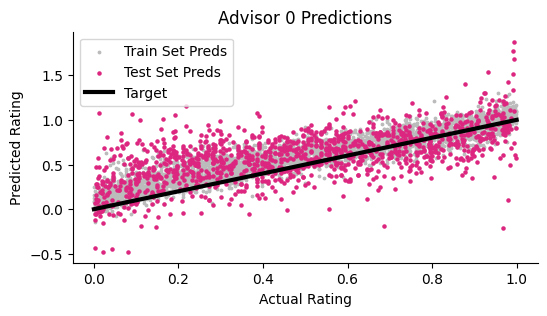

Advisor 0 Train Set R2 score: 0.7544406656007021
Advisor 0 Test Set R2 score: 0.10695786835827725


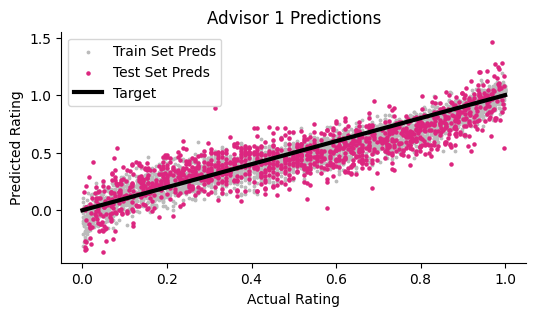

Advisor 1 Train Set R2 score: 0.8955995213917425
Advisor 1 Test Set R2 score: 0.7213327223993956


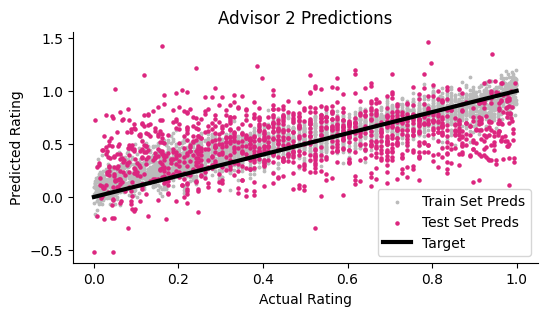

Advisor 2 Train Set R2 score: 0.8192444269408775
Advisor 2 Test Set R2 score: -0.09985420497394748


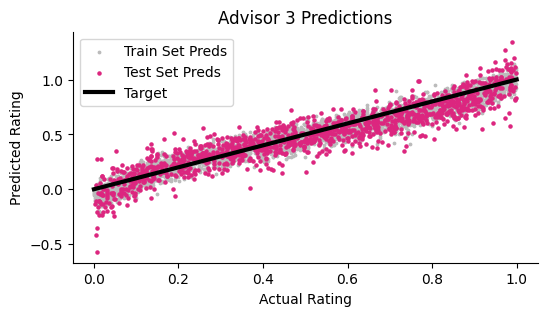

Advisor 3 Train Set R2 score: 0.9408326821575707
Advisor 3 Test Set R2 score: 0.8400126158792454


In [ ]:
all_predictions = [] #empty list to hold predictions

LR = LinearRegression()
GB = GradientBoostingRegressor(n_estimators=200, max_depth=5)
NN = MLPRegressor(hidden_layer_sizes=(200), max_iter=2000)

SS = StandardScaler()

model = GB

for i in range(0,4): #loop over four advisors
    predictions = fit_plot_predict(grids, ratings, i, model)
    all_predictions.append(predictions) #append predictions

## Selecting Best Grids:

Number of valid grids (as predicted): 200
Diversity score: 0.4544 


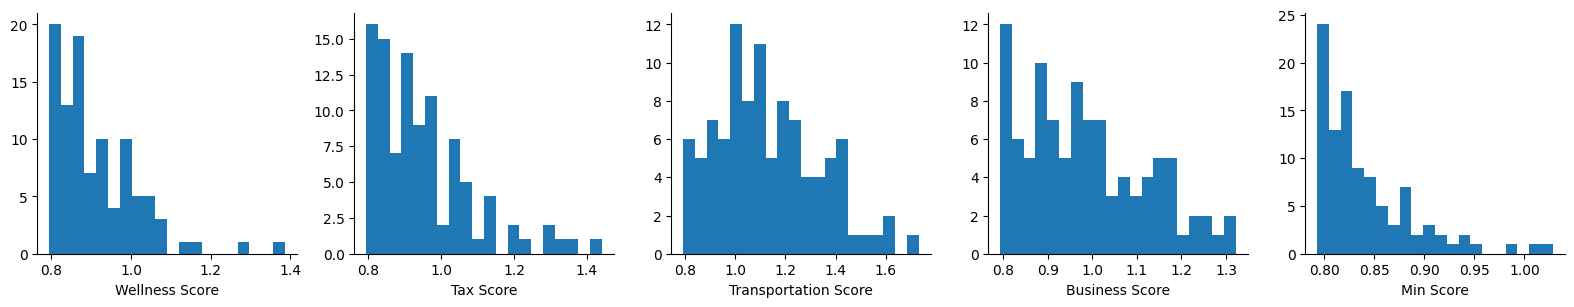

<Figure size 640x480 with 0 Axes>

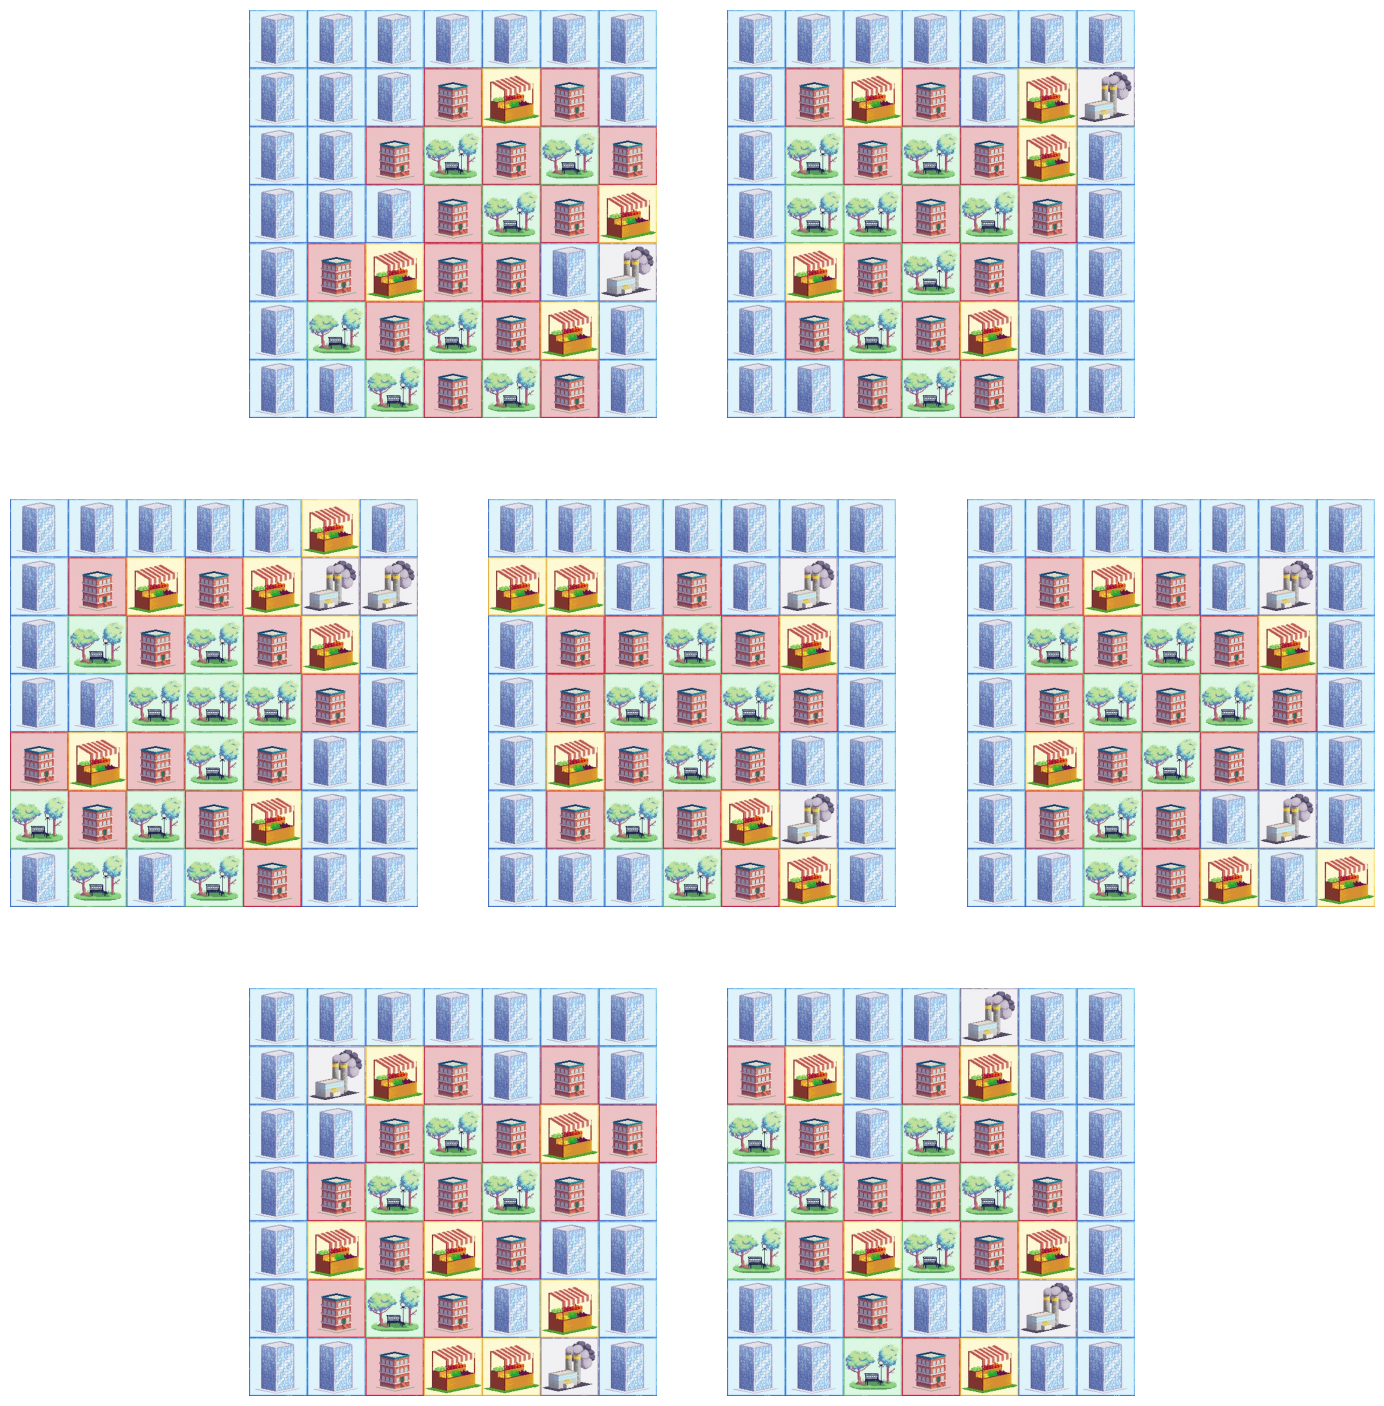

Submission saved


In [6]:
# TODO pick new grids if these are invalid, find a better way to pick grids
final_prediction_array = np.stack(all_predictions).T #stack the predictions
min_predictions = np.min(final_prediction_array, axis=1) #minimum advisor score (as predicted)
print(f"Number of valid grids (as predicted): {np.sum(min_predictions>0.75)}") #number of valid grids (as predicted)
top_100_indices = np.argpartition(min_predictions, -100)[-100:] #indices of top 100 designs (as sorted by minimum advisor score)
top_100_grids = grids[top_100_indices] #get the top 100 grids

score = diversity_score(top_100_grids)
print(f"Diversity score: {score:.4f} ")

plot_ratings_histogram(final_prediction_array[top_100_indices], withmin=True) #plot histograms of top 100 designs
plot_n_grids(top_100_grids[-7:])

final_submission = grids[top_100_indices].astype(int)
np.random.seed(42594)
id = np.random.randint(1e8, 1e9-1)
np.save(f"{id}.npy", final_submission)
print("Submission saved")